In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# # Load example data
# data_df = mavenn.load_example_dataset('sortseq')

# # Separate test from data_df
# ix_test = data_df['set']=='test'
# test_df = data_df[ix_test].reset_index(drop=True)
# print(f'test N: {len(test_df):,}')

# # Remove test data from data_df
# data_df = data_df[~ix_test].reset_index(drop=True)
# print(f'training + validation N: {len(data_df):,}')
# data_df.head()
#pd.read_csv
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
data_df = data_df_full[['x','SortSeq_bin1','SortSeq_bin2','SortSeq_bin3','SortSeq_bin4']].copy()
data_df.head(10)

,x,SortSeq_bin1,SortSeq_bin2,SortSeq_bin3,SortSeq_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,116,92,21,3
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,158,120,137,15
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,47,234,521,116
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,299,32,1,1
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,322,238,196,14
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,38,78,181,45
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1364,24,43,15
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,64,129,122,27
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,6,22


In [3]:
y_cols = data_df.columns[1:]

X = data_df['x']
y = data_df[y_cols]

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet_star=['A', 'C', 'D', 'E', 'F',
              'G', 'H', 'I', 'K', 'L',
              'M', 'N', 'P', 'Q', 'R',
              'S', 'T', 'V', 'W', 'Y','*']

alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=4


In [6]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-08-27 06:28:46.839759: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [7]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa = mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=Y,
                                                                      K=50,
                                                                      eta=1e-5,)


In [8]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa])

psi_my = (None, 4)
p_my = (None, 4)


In [9]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4024)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [10]:
# Set training data
model.set_data(x=x_train.values,
               y_list=[y_train.values],
               #validation_flags=(data_df['set']=='validation'),
               shuffle=True)


N = 83,880 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 10.4 sec.


In [11]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=150,
          batch_size=300,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/150
225/225 [==============================] - 7s 23ms/step - loss: 219581.1406 - I_var: -0.0139 - val_loss: 218661.4062 - val_I_var: -0.0060
Epoch 2/150
225/225 [==============================] - 3s 11ms/step - loss: 218299.5938 - I_var: -0.0025 - val_loss: 218536.1250 - val_I_var: -0.0049
Epoch 3/150
225/225 [==============================] - 2s 8ms/step - loss: 218300.4375 - I_var: 0.0023 - val_loss: 218518.8438 - val_I_var: -0.0048
Epoch 4/150
225/225 [==============================] - 2s 9ms/step - loss: 218298.8750 - I_var: -0.0030 - val_loss: 218578.4531 - val_I_var: -0.0053
Epoch 5/150
225/225 [==============================] - 3s 12ms/step - loss: 218283.9375 - I_var: -0.0017 - val_loss: 218476.3750 - val_I_var: -0.0044
Epoch 6/150
225/225 [==============================] - 2s 8ms/step - loss: 218310.6406 - I_var: 6.0423e-04 - val_loss: 218540.4688 - val_I_var: -0.0050
Epoch 7/150
225/225 [==============================] - 2s 8ms/step - loss: 218270.0156 - I_var: -0.00

225/225 [==============================] - 2s 10ms/step - loss: 190470.9531 - I_var: 0.2382 - val_loss: 196085.7969 - val_I_var: 0.1887
Epoch 57/150
225/225 [==============================] - 2s 8ms/step - loss: 190331.2656 - I_var: 0.2401 - val_loss: 194718.6562 - val_I_var: 0.2005
Epoch 58/150
225/225 [==============================] - 2s 8ms/step - loss: 190368.1250 - I_var: 0.2398 - val_loss: 194912.0156 - val_I_var: 0.1989
Epoch 59/150
225/225 [==============================] - 2s 9ms/step - loss: 190309.0156 - I_var: 0.2430 - val_loss: 194830.2656 - val_I_var: 0.1996
Epoch 60/150
225/225 [==============================] - 2s 8ms/step - loss: 190287.2812 - I_var: 0.2388 - val_loss: 195298.2656 - val_I_var: 0.1955
Epoch 61/150
225/225 [==============================] - 2s 8ms/step - loss: 190398.7656 - I_var: 0.2385 - val_loss: 194658.7188 - val_I_var: 0.2010
Epoch 62/150
225/225 [==============================] - 2s 8ms/step - loss: 190268.1406 - I_var: 0.2444 - val_loss: 195327.1

225/225 [==============================] - 2s 7ms/step - loss: 189808.7031 - I_var: 0.2462 - val_loss: 195389.7500 - val_I_var: 0.1946
Epoch 112/150
225/225 [==============================] - 2s 7ms/step - loss: 189854.0312 - I_var: 0.2441 - val_loss: 194454.6250 - val_I_var: 0.2027
Epoch 113/150
225/225 [==============================] - 2s 7ms/step - loss: 189813.1406 - I_var: 0.2433 - val_loss: 195323.4531 - val_I_var: 0.1952
Epoch 114/150
225/225 [==============================] - 2s 7ms/step - loss: 189876.9219 - I_var: 0.2432 - val_loss: 194232.4062 - val_I_var: 0.2046
Epoch 115/150
225/225 [==============================] - 2s 7ms/step - loss: 189772.6094 - I_var: 0.2488 - val_loss: 194203.3906 - val_I_var: 0.2048
Epoch 116/150
225/225 [==============================] - 2s 7ms/step - loss: 189773.0312 - I_var: 0.2447 - val_loss: 194208.7031 - val_I_var: 0.2048
Epoch 117/150
225/225 [==============================] - 2s 7ms/step - loss: 189877.7812 - I_var: 0.2410 - val_loss: 195

In [12]:
x_test

12178    NITNLCPFGEVFNATRFAGVYAWNRKRISNCVADYSVLYNSASFST...
60083    NITNLCPFGEVFNATRFASVYAWNRKRISNCSADYSVLYNSASFST...
86007    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
70249    NITNLCPFGTVFNATRFASVYAWNRKRISNCVADYSVLYNSPSFST...
51077    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
                               ...                        
42960    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
34133    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
78915    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
88131    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
50968    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
Name: x, Length: 9321, dtype: object

On test data:


Text(0.5, 1.0, 'training hisotry')

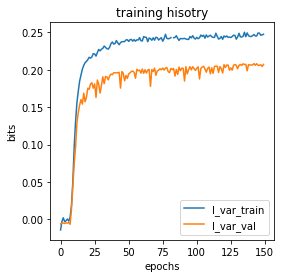

In [13]:
# Show training history
print('On test data:')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

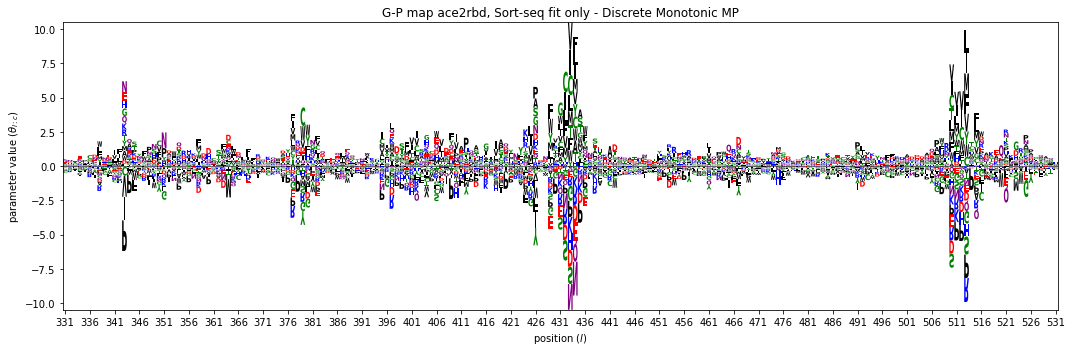

In [14]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map ace2rbd, Sort-seq fit only - Discrete Monotonic MP')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

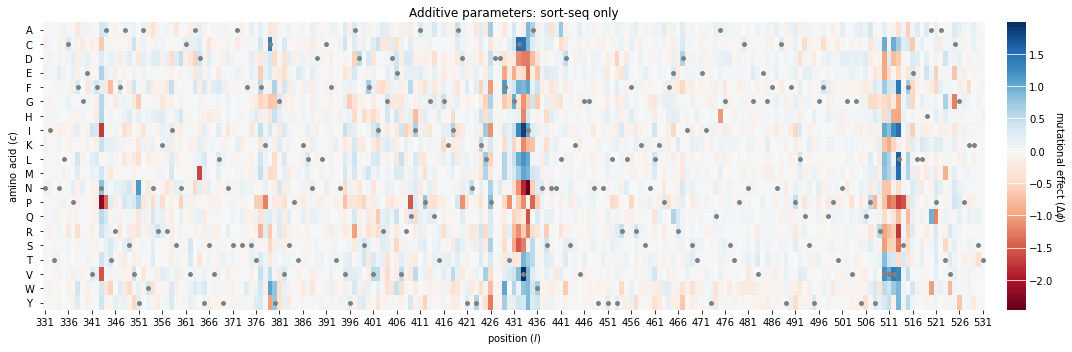

In [15]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=logo.df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [16]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')
bloom_single_mut_df.head(10)

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70
5,1,331,N,G,N331G,N1G,-0.06,-0.02,-0.04,-0.21,-0.29,-0.25
6,1,331,N,H,N331H,N1H,0.01,-0.05,-0.02,-0.86,-0.36,-0.61
7,1,331,N,I,N331I,N1I,-0.06,-0.08,-0.07,-1.05,-0.65,-0.85
8,1,331,N,K,N331K,N1K,-0.01,-0.01,-0.01,-0.17,-0.24,-0.20
9,1,331,N,L,N331L,N1L,-0.08,-0.01,-0.05,-0.81,-0.69,-0.75


In [17]:

bloom_exp_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    temp_df['expr_lib1']
    bloom_exp_df.loc[site-1] = temp_df['expr_lib1'].values[0:20]




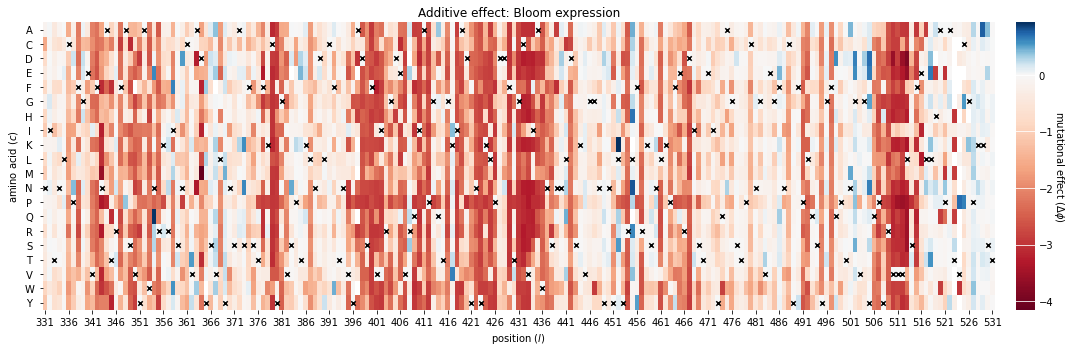

In [18]:
bloom_exp_df
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'black', 's':20,'marker':'x'},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive effect: Bloom expression')

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

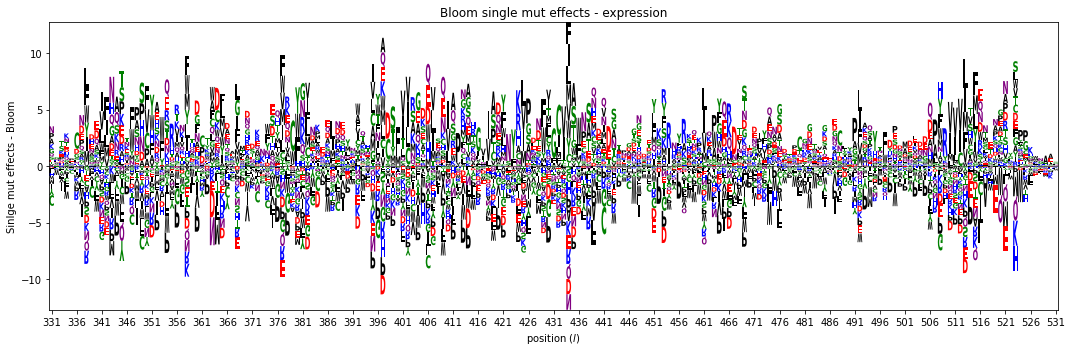

In [19]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(bloom_exp_df.fillna(0), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel('Sinlge mut effects - Bloom')
ax.set_xlabel(r'position ($l$)')
ax.set_title('Bloom single mut effects - expression')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

In [20]:
theta

array([[-0.00661498, -0.18968032, -0.05630291, ..., -0.04195167,
        -0.12914023, -0.07151576],
       [ 0.04071767,  0.11015646,  0.16508524, ...,  0.08963409,
         0.00921245,  0.03240293],
       [-0.15846567, -0.13989536, -0.11410672, ..., -0.171155  ,
        -0.19372962, -0.12120419],
       ...,
       [ 0.02409366, -0.0081638 , -0.1517915 , ..., -0.09875569,
        -0.11130289, -0.36857665],
       [-0.00799357, -0.02052237, -0.00394976, ..., -0.03665026,
        -0.05761236, -0.03980863],
       [ 0.01362031,  0.06547158, -0.01072077, ...,  0.05358332,
         0.03015511,  0.02844495]], dtype=float32)

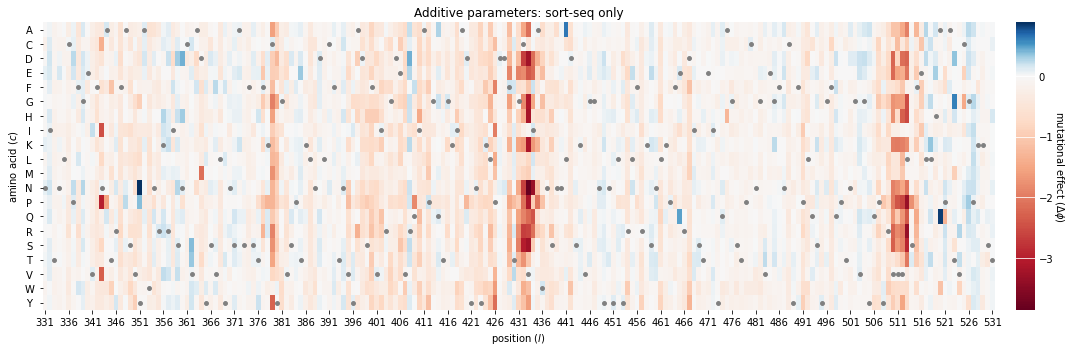

In [21]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [22]:
theta_raw_df = pd.DataFrame(np.squeeze(gpmap.weights[1].numpy()),columns=alphabet)
theta_raw_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,-0.006615,-0.189680,-0.056303,0.070863,-0.011662,0.010240,-0.038508,-0.053141,0.078082,-0.113693,-0.045912,0.071473,0.013088,0.007511,-0.029940,-0.005058,0.022474,-0.041952,-0.129140,-0.071516
1,0.040718,0.110156,0.165085,0.138800,0.082535,-0.025576,0.136066,0.057550,0.052389,0.062806,0.105144,0.176560,0.062157,0.124351,-0.025611,0.090037,0.087142,0.089634,0.009212,0.032403
2,-0.158466,-0.139895,-0.114107,-0.110968,-0.183113,-0.112762,-0.197264,-0.216279,-0.167973,-0.192721,-0.165751,-0.134741,-0.152505,-0.079507,-0.148038,-0.107647,-0.056693,-0.171155,-0.193730,-0.121204
3,-0.083118,-0.159378,0.038334,0.150151,-0.164873,-0.068030,-0.070023,-0.192117,0.040395,-0.124624,-0.062255,-0.006366,-0.165200,-0.155318,-0.010393,-0.036068,0.006906,-0.140964,-0.145748,-0.165114
4,0.008140,-0.158706,-0.150920,0.009885,-0.041202,-0.048549,-0.076581,-0.204456,-0.093619,-0.078342,-0.158930,-0.084988,0.033284,-0.088859,-0.087989,-0.111258,-0.064951,-0.050309,-0.063765,-0.072338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.180386,0.015263,0.106870,-0.074107,0.011111,0.242529,0.087916,0.206154,0.176353,0.206826,0.179171,0.197789,0.061091,0.071874,0.112981,0.101661,-0.023502,0.142753,0.072705,0.126095
197,-0.014553,-0.010283,-0.065419,-0.002212,-0.450893,0.067720,0.035223,-0.063169,0.022555,0.033042,0.070164,0.045059,-0.130702,0.141795,-0.008710,0.102026,0.071448,0.099627,0.107629,0.077592
198,0.024094,-0.008164,-0.151791,-0.213298,-0.133315,-0.125289,-0.122543,-0.082564,-0.135034,-0.276720,-0.105089,-0.094172,-0.266791,-0.025797,-0.145538,-0.073994,-0.274784,-0.098756,-0.111303,-0.368577
199,-0.007994,-0.020522,-0.003950,-0.020428,-0.034368,0.016312,-0.140421,-0.087607,-0.081051,-0.103593,-0.112229,-0.086584,-0.019710,0.067448,-0.041854,-0.062479,-0.433212,-0.036650,-0.057612,-0.039809


In [23]:
# del bloom_exp_df['*']
# del theta_raw_df['*']

Text(0, 0.5, 'MAVE-NN2, G-P map')

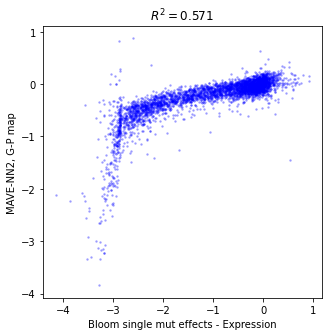

In [24]:
plt.figure(figsize=(5,5))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_raw_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values, theta_raw_df.values,s=2.5,alpha=0.25,color='blue')

#lims = [-3,1]
#plt.plot(lims,lims,'--')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'$R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')

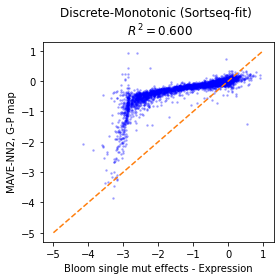

In [25]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

plt.figure(figsize=(4,4))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values.ravel(), theta_lc_consensus_df.values.ravel(),s=2.5,alpha=0.25,color='blue')

lims = [-5,1]
plt.plot(lims,lims,'--',color='C1')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'Discrete-Monotonic (Sortseq-fit) \n $R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')
plt.tight_layout()
plt.savefig('mavenn_bloom_expression_comparison.png',dpi=200,bbox_inches='tight')

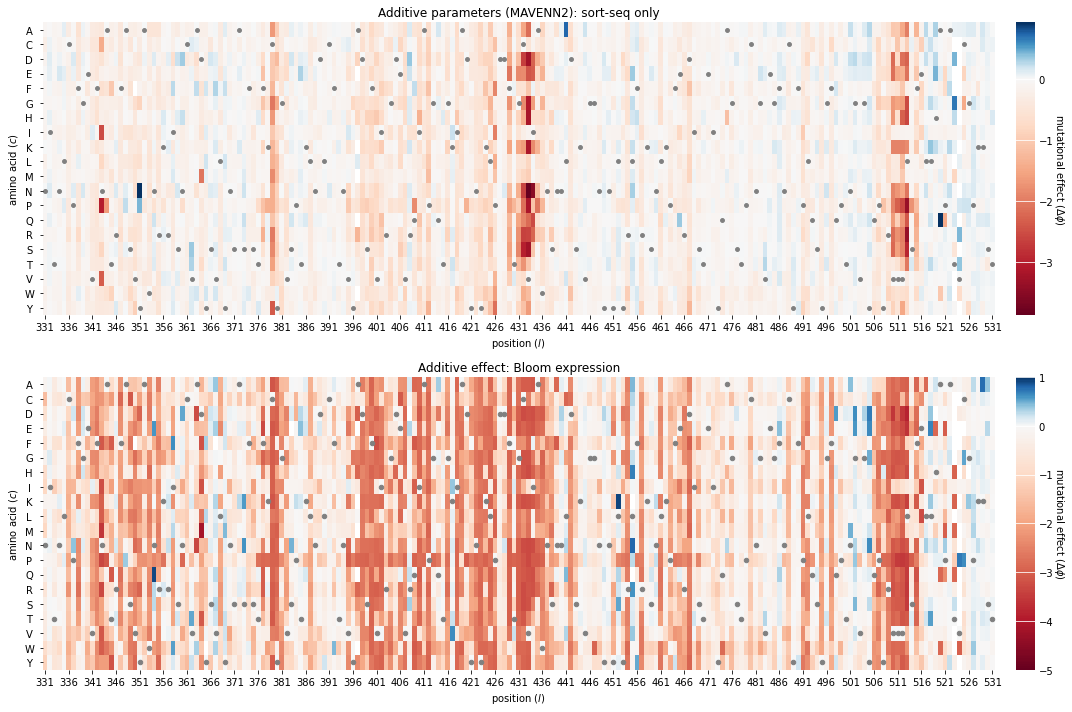

In [26]:

# Create figure
fig, axs = plt.subplots(2,1, figsize=(15,10))

# Draw heatmap
ax = axs[0]

heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta_lc,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters (MAVENN2): sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
#fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

bloom_exp_df
# Create figure
#fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
ax = axs[1]

heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                                cmap='RdBu',
                                cbar=True,
                                clim = [-5,1],
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive effect: Bloom expression')

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
fig.savefig('ace2rbd_g-p_map_discrete_monotonic_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [27]:
mavenn.heatmap?

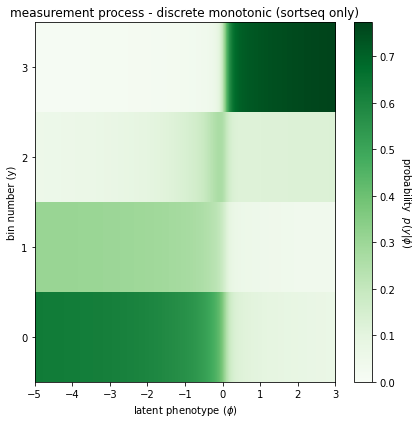

In [28]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)


# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,6])

# Right panel: draw measurement process as heatmap
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - discrete monotonic (sortseq only)')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()
fig.savefig('ace2rbd_mpa_measurment_prcoess_sortseq_only.png',dpi=300,bbox_inches='tight')


In [29]:
np.save('sortseq_gpmap_monotonic_agnostic',logo.df.values.ravel())
#np.save('sortseq_gpmap_discrete_agnostic',theta.ravel())